# SVM - BIGRAM 


### A. IMPORT LIBS AND READING CONSOLIDATED DATA

In [1]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder
import numpy as np
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
#install spacy
#import spacy
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.pipeline import FeatureUnion, Pipeline
from scipy.sparse import hstack
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, precision_score, accuracy_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import BaggingClassifier

In [2]:
data = pd.read_csv( r"C:\Users\Janit\Downloads\consolidated.csv")
data

,Unnamed: 0,mail_id,mail_hash,mail_text,mail_cat
0,0,2170,78c282a5e417d6d231dc75aa8588ebb7,From rssfeeds@jmason.org Mon Sep 30 13:43:46 ...,ham
1,1,113,1d37bdbcad4975b5012cc6d87a048ecf,Return-Path: <bounce-lghtml-2534368@sprocket.l...,ham
2,2,769,25bf9a767b5db0ed93f03c1637281663,From fork-admin@xent.com Tue Sep 24 17:55:30 ...,ham
3,3,1074,8590d61ac0aeeadb58dc2f2ba776c406,From rpm-list-admin@freshrpms.net Mon Sep 9 ...,ham
4,4,2479,14365bcad3a60fcf24c5c1813f6291fb,From secprog-return-625-jm=jmason.org@security...,ham
...,...,...,...,...,...
7951,7951,851,dc5452f80ba0bb8481dfc48f70380c4d,From mraimecoilcipc@msn.com Mon Jul 22 18:39:...,spam
7952,7952,1328,b23902de23cb3ca1f3334517282372b2,From fork-admin@xent.com Thu Aug 8 14:37:34 ...,spam
7953,7953,1244,9ef966101737a6fc27d8965def288d70,From niddeel@hotmail.com Tue Aug 6 10:54:56 ...,spam
7954,7954,13,d3f0b591a65f116ea5d9d4ad919f83aa,From aileen@email2.qves.net Fri Aug 23 11:03:...,spam


In [3]:
## testing and trying by converting in string earlier.  
#### CONVERTED INTO STRING 
##text_string = data['mail_text'].str.cat()
###text_string

In [4]:
### WITHOUT USING FROM 
### this was the first time i tried to extract the "from: " section from the email without using it 


#pattern = re.compile(r'[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}')
#from_emails_without = pattern.findall(text_string)
#from_emails_without

## B. PRE-PREOCESSING OF DATA

#### 1. EXTRACTING THE POSSIBLE FEATURES FROM THE MAIL AND CREATING A STRUCTRED DATAFRAME


In [5]:
#### EXTRACTING THE BODY AND HEADER OF MAILS 
Data_text = pd.DataFrame(data[['mail_text']])    #selecting the content of the mails
data_body_head = pd.DataFrame()
def split_email_hb(text):
    head, body = text.split("\n\n", 1)   
    return pd.Series([head, body])  

data_body_head[['HEADER', 'BODY']]  = Data_text["mail_text"].apply(split_email_hb)

### With the help of for loop and patterns I extracted different features and then added back into the data frame. 

              
for x in Data_text:                                        # applying the loop putting the emails in a value and then applying pattern of extractaction usign regrex
    text_string = Data_text[x]
## PATTERN APPLIED FOR "From :"
    pattern1 = re.compile(r'\bFrom[: ]\s*([A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,})\b')        
## PATTERN APPLIED FOR "To :"
    pattern2 = re.compile(r'\bTo[: ]\s*([A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,})\b')
## PATTERN APPLIED FOR "Subject :"
    pattern3 = re.compile(r'Subject:\s*(.*)', re.IGNORECASE)
## PATTERN APPLIED FOR "MESSAGE ID :"
    pattern4 = re.compile(r'Message-ID:\s*<([^>]+)>', re.IGNORECASE)
## PATTERN APPLIED FOR "MIME version"
    pattern5 = re.compile(r'MIME-Version:\s+(\d+\.\d+)')
## PATTERN APPLIED FOR "CONTENT TYPE: "    
    pattern6 = re.compile(r'Content-Type:\s+([^;\r\n]+)')
## PATTERN APPLIED FOR "CHART TYPE: "
    pattern7 = charset_pattern = re.compile(r'charset="([^"]+)"')
    
#### ASSIGNING EACH PATTERN TO CREATE A NEW COLUMN WITH SIMILAR ROWS:-
    data_from_mail = Data_text.assign(From=Data_text['mail_text'].str.extract(pattern1, expand=False)) #from
    data_to_mail = Data_text.assign(To=Data_text['mail_text'].str.extract(pattern2, expand=False)) #to
    data_SUBJECT = Data_text.assign(Subject=Data_text['mail_text'].str.extract(pattern3, expand=False)) #subject
    data_messageID = Data_text.assign(MessageID=Data_text['mail_text'].str.extract(pattern4, expand=False)) #messageid
    data_mime = Data_text.assign(Mime_Type=Data_text['mail_text'].str.extract(pattern5, expand=False)) #mime type
    data_contype = Data_text.assign(Content_Type=Data_text['mail_text'].str.extract(pattern6, expand=False)) #content type
    data_charset = Data_text.assign(Charset_Type=Data_text['mail_text'].str.extract(pattern7, expand=False)) #charset type

    
#result

print("Extracted header and body: \n" , data_body_head,"\n===============================================\n\n") 
print("Extracted From: \n" , data_from_mail,"\n===============================================\n\n") 
print("Extracted To: \n" , data_to_mail,"\n===============================================\n\n") 
print("Extracted Subject : \n" , data_SUBJECT,"\n===============================================\n\n") 
print("Extracted messageID : \n" , data_messageID,"\n===============================================\n\n") 
print("Extracted MIME type : \n" , data_mime,"\n===============================================\n\n") 
print("Extracted contype : \n" , data_contype,"\n===============================================\n\n") 
print("Extracted charset : \n" , data_charset,"\n===============================================\n\n") 

Extracted header and body: 
                                                  HEADER  \
0     From rssfeeds@jmason.org  Mon Sep 30 13:43:46 ...   
1     Return-Path: <bounce-lghtml-2534368@sprocket.l...   
2     From fork-admin@xent.com  Tue Sep 24 17:55:30 ...   
3     From rpm-list-admin@freshrpms.net  Mon Sep  9 ...   
4     From secprog-return-625-jm=jmason.org@security...   
...                                                 ...   
7951  From mraimecoilcipc@msn.com  Mon Jul 22 18:39:...   
7952  From fork-admin@xent.com  Thu Aug  8 14:37:34 ...   
7953  From niddeel@hotmail.com  Tue Aug  6 10:54:56 ...   
7954  From aileen@email2.qves.net  Fri Aug 23 11:03:...   
7955  Received: from actioncouriers.com ([207.225.37...   

                                                   BODY  
0     URL: http://www.newsisfree.com/click/-1,838114...  
1     <html><head><!--\n\n\n      CLICK HERE to read...  
2     \nIn a message dated 9/24/2002 11:24:58 AM, ja...  
3     Hiya, I always seem to g

In [6]:
#### ADDING THE COLUMNS IN THE ORIGINAL DATA#
E_Data = pd.DataFrame
E_Data = pd.concat([data, data_body_head['HEADER'],data_body_head['BODY'] , data_from_mail['From'], data_to_mail['To'], data_SUBJECT['Subject'],data_messageID['MessageID'],data_mime['Mime_Type'], data_contype['Content_Type'],data_charset['Charset_Type']], axis=1)
#### dropping Unnamed as it is not needed
E_Data.drop(columns='Unnamed: 0')

,mail_id,mail_hash,mail_text,mail_cat,HEADER,BODY,From,To,Subject,MessageID,Mime_Type,Content_Type,Charset_Type
0,2170,78c282a5e417d6d231dc75aa8588ebb7,From rssfeeds@jmason.org Mon Sep 30 13:43:46 ...,ham,From rssfeeds@jmason.org Mon Sep 30 13:43:46 ...,"URL: http://www.newsisfree.com/click/-1,838114...",rssfeeds@jmason.org,yyyy@localhost.example.com,Priceless Rubens works stolen in raid on mansion,200209300801.g8U81fg21359@dogma.slashnull.org,NaN,text/plain,NaN
1,113,1d37bdbcad4975b5012cc6d87a048ecf,Return-Path: <bounce-lghtml-2534368@sprocket.l...,ham,Return-Path: <bounce-lghtml-2534368@sprocket.l...,<html><head><!--\n\n\n CLICK HERE to read...,NaN,qqqqqqqqqq-lg@spamassassin.taint.org,[Lockergnome Windows Daily] Sticker Courtesy,LISTMANAGERSQL-2534368-1682723-2002.07.18-09.5...,1.0,text/html,NaN
2,769,25bf9a767b5db0ed93f03c1637281663,From fork-admin@xent.com Tue Sep 24 17:55:30 ...,ham,From fork-admin@xent.com Tue Sep 24 17:55:30 ...,"\nIn a message dated 9/24/2002 11:24:58 AM, ja...",fork-admin@xent.com,yyyy@localhost.spamassassin.taint.org,Re: liberal defnitions,1a3.92f0d57.2ac1e836@aol.com,1.0,text/plain,US-ASCII
3,1074,8590d61ac0aeeadb58dc2f2ba776c406,From rpm-list-admin@freshrpms.net Mon Sep 9 ...,ham,From rpm-list-admin@freshrpms.net Mon Sep 9 ...,"Hiya, I always seem to get errors when I do an...",rpm-list-admin@freshrpms.net,yyyy@localhost.spamassassin.taint.org,problems with apt update,14220000.1012602017@spawn.se7en.org,1.0,text/plain,NaN
4,2479,14365bcad3a60fcf24c5c1813f6291fb,From secprog-return-625-jm=jmason.org@security...,ham,From secprog-return-625-jm=jmason.org@security...,\nI don't know how one can expect better and m...,NaN,yyyy@localhost.spamassassin.taint.org,Re: Are bad developer libraries the problem wi...,20021125202526.GA9488@nsk.no-ip.org,1.0,text/plain,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7951,851,dc5452f80ba0bb8481dfc48f70380c4d,From mraimecoilcipc@msn.com Mon Jul 22 18:39:...,spam,From mraimecoilcipc@msn.com Mon Jul 22 18:39:...,<html>\n<HEAD> \n<TITLE>creditfix</TITLE> \n</...,mraimecoilcipc@msn.com,yyyy@localhost.netnoteinc.com,Fix Your credit Yourself ONLINE!! ...,00007d9466bd$0000156d$000076df@smtp-gw-4.msn.com,1.0,text/html,iso-8859-1
7952,1328,b23902de23cb3ca1f3334517282372b2,From fork-admin@xent.com Thu Aug 8 14:37:34 ...,spam,From fork-admin@xent.com Thu Aug 8 14:37:34 ...,Hello:\n\nAre you satisfied with your ISP? Do ...,fork-admin@xent.com,yyyy@localhost.netnoteinc.com,New Internet Service Provider,016b21e80d5a$4541e5a5$2aa76de7@ccitih,1.0,text/plain,iso-8859-1
7953,1244,9ef966101737a6fc27d8965def288d70,From niddeel@hotmail.com Tue Aug 6 10:54:56 ...,spam,From niddeel@hotmail.com Tue Aug 6 10:54:56 ...,<html><HEAD><TITLE>creditfix</TITLE> \n</HEAD>...,niddeel@hotmail.com,yyyy@localhost.netnoteinc.com,Bad Credit Breakthrough!!! 6465,00001c185fee$00002512$00006600@mx14.hotmail.com,1.0,text/html,iso-8859-1
7954,13,d3f0b591a65f116ea5d9d4ad919f83aa,From aileen@email2.qves.net Fri Aug 23 11:03:...,spam,From aileen@email2.qves.net Fri Aug 23 11:03:...,1) Fight The Risk of Cancer!\nhttp://www.adcli...,aileen@email2.qves.net,zzzz@localhost.spamassassin.taint.org,Get the Child Support You Deserve ...,110d1201c24a20$29b657e0$1406fea9@freeyankeedom...,1.0,text/plain,iso-8859-1


#### 2. CLEANING THE DATA

In [7]:
### checking the type of data
E_Data.dtypes

Unnamed: 0       int64
mail_id          int64
mail_hash       object
mail_text       object
mail_cat        object
HEADER          object
BODY            object
From            object
To              object
Subject         object
MessageID       object
Mime_Type       object
Content_Type    object
Charset_Type    object
dtype: object

In [8]:
### checking null values
E_Data.isnull().sum()

Unnamed: 0         0
mail_id            0
mail_hash          0
mail_text          0
mail_cat           0
HEADER             0
BODY               0
From             482
To               516
Subject            6
MessageID         11
Mime_Type       2713
Content_Type    1158
Charset_Type    5719
dtype: int64

### So, the meaning and significance of overall features are: 
#### mail_id = unique ID of the file given
#### mail_hash = unique sequece after mail_id of the the given file
#### mail_text = overall content of the mail in the given file
#### mail_cat  = Actual category of the email
#### Header, Body = To distunguish the body of email/message.
#### From = Origin of message coming from
#### To = Recieved to whom.
#### Subject = Subject of the mail
#### MessageID = unique identifier that helps in tracking and identifying an email message
#### Mime_Type =  Internet standard that extends the format of email messages
#### Content_Type = Type of content text/plain or html
#### Charset_Type = A "charset" parameter may be used to indicate the character set of the body text. 

### Tech 1: Thus, majority of null/NAN values are in the Charset_Type, Content_Type, Mime_Type and "Message ID" and as they do not have any significance upon prediction of spam or ham as well as with having more than 20% of missing values, it is better to remove the whole column.

### Tech 2: It is convienent to drop the rows of missing "From", "To" and "Subject"  as there is no technique or way to figure out the values as it can be sent from anyone about anything

### Tech 3: Removal of  'HEADER', 'mail_ID' , 'mail_hash' , 'mail_text' ,  column is necessary as it was only use for structuring and will effect the tokenization.


In [9]:
### REMOVING THE ROWS AND COLUMNS

## TECH 1 

E_Data = E_Data.drop(columns = 'Mime_Type' )
E_Data = E_Data.drop(columns = 'Content_Type')
E_Data = E_Data.drop(columns = 'Charset_Type')
E_Data = E_Data.drop(columns = 'MessageID')


## TECH 2

E_Data = E_Data.dropna(subset=['From'])
E_Data = E_Data.dropna(subset=['To'])
E_Data = E_Data.dropna(subset=['Subject'])

## TECH 3 
E_Data = E_Data.drop(columns = 'HEADER')
E_Data = E_Data.drop(columns = 'mail_id')
E_Data = E_Data.drop(columns = 'mail_hash')
E_Data = E_Data.drop(columns = 'mail_text')

In [10]:
## DROPPING UNNAMED
E_Data = E_Data.drop(columns = 'Unnamed: 0')
E_Data

,mail_cat,BODY,From,To,Subject
0,ham,"URL: http://www.newsisfree.com/click/-1,838114...",rssfeeds@jmason.org,yyyy@localhost.example.com,Priceless Rubens works stolen in raid on mansion
2,ham,"\nIn a message dated 9/24/2002 11:24:58 AM, ja...",fork-admin@xent.com,yyyy@localhost.spamassassin.taint.org,Re: liberal defnitions
3,ham,"Hiya, I always seem to get errors when I do an...",rpm-list-admin@freshrpms.net,yyyy@localhost.spamassassin.taint.org,problems with apt update
5,ham,> > You're probably running exmh on a local ma...,exmh-users-admin@redhat.com,yyyy@localhost.example.com,Re: Sorting
6,ham,"On Sun, 1 Sep 2002, Reza B'Far (eBuilt) wrote:...",fork-admin@xent.com,yyyy@localhost.netnoteinc.com,RE: Java is for kiddies
...,...,...,...,...,...
7950,spam,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",687ifsuy@bol.com.br,yyyy@localhost.netnoteinc.com,>> Best rates on mortgage in the country! <
7951,spam,<html>\n<HEAD> \n<TITLE>creditfix</TITLE> \n</...,mraimecoilcipc@msn.com,yyyy@localhost.netnoteinc.com,Fix Your credit Yourself ONLINE!! ...
7952,spam,Hello:\n\nAre you satisfied with your ISP? Do ...,fork-admin@xent.com,yyyy@localhost.netnoteinc.com,New Internet Service Provider
7953,spam,<html><HEAD><TITLE>creditfix</TITLE> \n</HEAD>...,niddeel@hotmail.com,yyyy@localhost.netnoteinc.com,Bad Credit Breakthrough!!! 6465


In [11]:
## chanigng from object to string
E_Data = E_Data.astype(str)
E_Data

,mail_cat,BODY,From,To,Subject
0,ham,"URL: http://www.newsisfree.com/click/-1,838114...",rssfeeds@jmason.org,yyyy@localhost.example.com,Priceless Rubens works stolen in raid on mansion
2,ham,"\nIn a message dated 9/24/2002 11:24:58 AM, ja...",fork-admin@xent.com,yyyy@localhost.spamassassin.taint.org,Re: liberal defnitions
3,ham,"Hiya, I always seem to get errors when I do an...",rpm-list-admin@freshrpms.net,yyyy@localhost.spamassassin.taint.org,problems with apt update
5,ham,> > You're probably running exmh on a local ma...,exmh-users-admin@redhat.com,yyyy@localhost.example.com,Re: Sorting
6,ham,"On Sun, 1 Sep 2002, Reza B'Far (eBuilt) wrote:...",fork-admin@xent.com,yyyy@localhost.netnoteinc.com,RE: Java is for kiddies
...,...,...,...,...,...
7950,spam,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",687ifsuy@bol.com.br,yyyy@localhost.netnoteinc.com,>> Best rates on mortgage in the country! <
7951,spam,<html>\n<HEAD> \n<TITLE>creditfix</TITLE> \n</...,mraimecoilcipc@msn.com,yyyy@localhost.netnoteinc.com,Fix Your credit Yourself ONLINE!! ...
7952,spam,Hello:\n\nAre you satisfied with your ISP? Do ...,fork-admin@xent.com,yyyy@localhost.netnoteinc.com,New Internet Service Provider
7953,spam,<html><HEAD><TITLE>creditfix</TITLE> \n</HEAD>...,niddeel@hotmail.com,yyyy@localhost.netnoteinc.com,Bad Credit Breakthrough!!! 6465


In [12]:
### HAM = 1 && SPAM = 0
E_Data['mail_cat'] = np.where(E_Data['mail_cat'] == 'spam', 0, 1)


#### 3. TOKENIZATION

In [13]:
%%time
### APPLYING TOKENIZATION OF COLUMNS



def tokenize(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token.lower() not in stop_words]
    return tokens
# Apply tokenization to the 'text' column
E_Data['tokens_BODY'] = E_Data['BODY'].apply(tokenize)
E_Data['tokens_From'] = E_Data['From'].apply(tokenize)
E_Data['tokens_To'] = E_Data['To'].apply(tokenize)
E_Data['tokens_Subject'] = E_Data['Subject'].apply(tokenize)

CPU times: total: 23.6 s
Wall time: 23.7 s


In [14]:
E_Data

,mail_cat,BODY,From,To,Subject,tokens_BODY,tokens_From,tokens_To,tokens_Subject
0,1,"URL: http://www.newsisfree.com/click/-1,838114...",rssfeeds@jmason.org,yyyy@localhost.example.com,Priceless Rubens works stolen in raid on mansion,"[URL, :, http, :, //www.newsisfree.com/click/-...","[rssfeeds, @, jmason.org]","[yyyy, @, localhost.example.com]","[Priceless, Rubens, works, stolen, raid, mansion]"
2,1,"\nIn a message dated 9/24/2002 11:24:58 AM, ja...",fork-admin@xent.com,yyyy@localhost.spamassassin.taint.org,Re: liberal defnitions,"[message, dated, 9/24/2002, 11:24:58, ,, james...","[fork-admin, @, xent.com]","[yyyy, @, localhost.spamassassin.taint.org]","[:, liberal, defnitions]"
3,1,"Hiya, I always seem to get errors when I do an...",rpm-list-admin@freshrpms.net,yyyy@localhost.spamassassin.taint.org,problems with apt update,"[Hiya, ,, always, seem, get, errors, ``, apt, ...","[rpm-list-admin, @, freshrpms.net]","[yyyy, @, localhost.spamassassin.taint.org]","[problems, apt, update]"
5,1,> > You're probably running exmh on a local ma...,exmh-users-admin@redhat.com,yyyy@localhost.example.com,Re: Sorting,"[>, >, 're, probably, running, exmh, local, ma...","[exmh-users-admin, @, redhat.com]","[yyyy, @, localhost.example.com]","[:, Sorting]"
6,1,"On Sun, 1 Sep 2002, Reza B'Far (eBuilt) wrote:...",fork-admin@xent.com,yyyy@localhost.netnoteinc.com,RE: Java is for kiddies,"[Sun, ,, 1, Sep, 2002, ,, Reza, B'Far, (, eBui...","[fork-admin, @, xent.com]","[yyyy, @, localhost.netnoteinc.com]","[:, Java, kiddies]"
...,...,...,...,...,...,...,...,...,...
7950,0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",687ifsuy@bol.com.br,yyyy@localhost.netnoteinc.com,>> Best rates on mortgage in the country! <,"[<, !, DOCTYPE, HTML, PUBLIC, ``, -//W3C//DTD,...","[687ifsuy, @, bol.com.br]","[yyyy, @, localhost.netnoteinc.com]","[>, >, Best, rates, mortgage, country, !, <]"
7951,0,<html>\n<HEAD> \n<TITLE>creditfix</TITLE> \n</...,mraimecoilcipc@msn.com,yyyy@localhost.netnoteinc.com,Fix Your credit Yourself ONLINE!! ...,"[<, html, >, <, HEAD, >, <, TITLE, >, creditfi...","[mraimecoilcipc, @, msn.com]","[yyyy, @, localhost.netnoteinc.com]","[Fix, credit, ONLINE, !, !, 12678]"
7952,0,Hello:\n\nAre you satisfied with your ISP? Do ...,fork-admin@xent.com,yyyy@localhost.netnoteinc.com,New Internet Service Provider,"[Hello, :, satisfied, ISP, ?, 5, email, addres...","[fork-admin, @, xent.com]","[yyyy, @, localhost.netnoteinc.com]","[New, Internet, Service, Provider]"
7953,0,<html><HEAD><TITLE>creditfix</TITLE> \n</HEAD>...,niddeel@hotmail.com,yyyy@localhost.netnoteinc.com,Bad Credit Breakthrough!!! 6465,"[<, html, >, <, HEAD, >, <, TITLE, >, creditfi...","[niddeel, @, hotmail.com]","[yyyy, @, localhost.netnoteinc.com]","[Bad, Credit, Breakthrough, !, !, !, 6465]"


# C. MODELLING

### 1.  ---- BASE LINE MODEL------

In [15]:
### TEST TRAIN SPLIT 
X_train, X_test, Y_train, Y_test = train_test_split(E_Data[['BODY','From','To','Subject','tokens_BODY','tokens_From','tokens_To','tokens_Subject']], E_Data['mail_cat'], test_size=0.3)

In [16]:
%%time
vectorizers = {}
X_train_transformed_list = []
X_test_transformed_list = []
# Converting columns into string
for column in ['tokens_BODY', 'tokens_From', 'tokens_To', 'tokens_Subject','tokens_To','tokens_Subject']:
    X_train[column] = X_train[column].apply(' '.join)
    X_test[column] = X_test[column].apply(' '.join)
    
X = E_Data[['BODY','From','To','Subject','tokens_BODY']]
Y = E_Data['mail_cat']

## Vectorizes each column separetedly
for column in X:
    vectorizers[column] = CountVectorizer(ngram_range=(2, 2))  # 2x2 = bi-gramas

    X_train_transformed_list.append(vectorizers[column].fit_transform(X_train[column]))
    X_test_transformed_list.append(vectorizers[column].transform(X_test[column]))
    
## This code arranges  generete lists into a unique column
X_train_transformed = hstack(X_train_transformed_list)
X_test_transformed = hstack(X_test_transformed_list)
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_transformed, Y_train)


Y_pred = svm_model.predict(X_test_transformed)

CPU times: total: 21.3 s
Wall time: 21.3 s


In [17]:
Y_pred

array([1, 1, 1, ..., 1, 0, 1])

In [18]:

def evauate(Y_pred,Y_test):
    accuarcy=accuracy_score(Y_test,Y_pred)
    
    print("Accuarcy:", accuarcy)
    print(classification_report(Y_test,Y_pred))
    
    
    conf_matrix = confusion_matrix(Y_test,Y_pred)
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    probabilities = svm_model.predict(X_test_transformed)
    fpr,tpr,thresholds=roc_curve(Y_test, probabilities) 
    roc_auc=auc(fpr,tpr)
    print("ROC_AUC: ",roc_auc )
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    

Accuarcy: 0.988112220637185
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       398
           1       0.99      0.99      0.99      1705

    accuracy                           0.99      2103
   macro avg       0.98      0.98      0.98      2103
weighted avg       0.99      0.99      0.99      2103



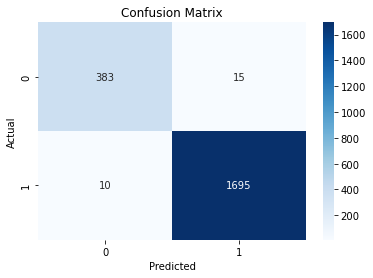

ROC_AUC:  0.9782232275748243


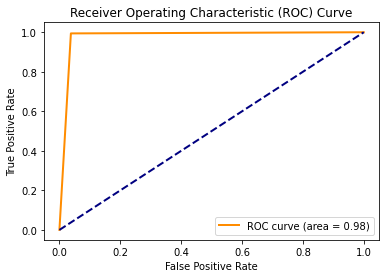

In [19]:
evauate(Y_pred,Y_test)

# D. TUNING w/ confusion matrix result


### 1. Using cross-validation  

In [20]:
%%time
cross_val_scores = cross_val_score(svm_model, X_train_transformed, Y_train, cv=5)
print("Cross-validation scores:", cross_val_scores)

Cross-validation scores: [0.98674822 0.98369011 0.98878695 0.98674822 0.99184506]
CPU times: total: 50.9 s
Wall time: 50.9 s


In [21]:
print("Average cross-validation score:", np.mean(cross_val_scores))

Average cross-validation score: 0.9875637104994903


### 2. Adding probability factor in svm_model

Accuarcy: 0.988112220637185
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       398
           1       0.99      0.99      0.99      1705

    accuracy                           0.99      2103
   macro avg       0.98      0.98      0.98      2103
weighted avg       0.99      0.99      0.99      2103



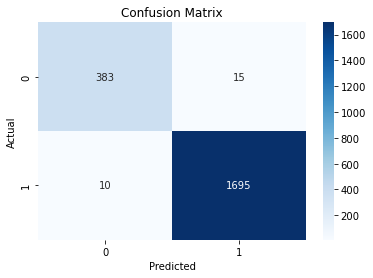

ROC_AUC:  0.9782232275748243


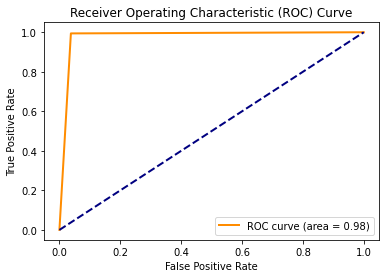

CPU times: total: 1min 12s
Wall time: 1min 12s


In [22]:
%%time
svm_model1 = SVC(kernel='linear' , probability = True)
svm_model1.fit(X_train_transformed, Y_train)


Y_pred1 = svm_model1.predict(X_test_transformed)

evauate(Y_pred1,Y_test)

### 3. Bagging_Model

Accuarcy: 0.9862101759391345
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       398
           1       0.99      0.99      0.99      1705

    accuracy                           0.99      2103
   macro avg       0.98      0.97      0.98      2103
weighted avg       0.99      0.99      0.99      2103



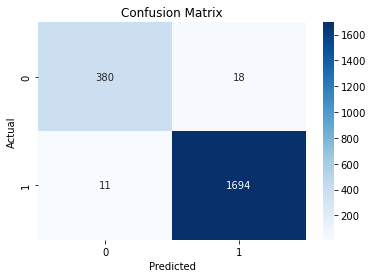

ROC_AUC:  0.9782232275748243


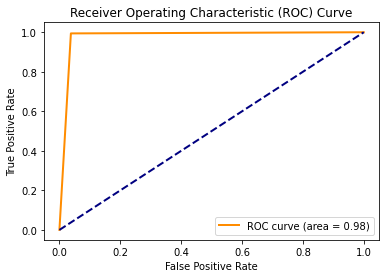

In [25]:
svm_model2 = SVC(kernel='linear', C=2.0)

# Initialize the BaggingClassifier with SVM as the base model
bagging_model = BaggingClassifier(svm_model2, n_estimators=10, random_state=42)

# Fit the ensemble model to training data
bagging_model.fit(X_train_transformed, Y_train)

# Make predictions
Y_pred3 = bagging_model.predict(X_test_transformed)

evauate(Y_pred3,Y_test)

# After trying these 3 tuning menthods, the accuracy we recieved are:

## Baseline Model        = 0.98811
## Crossvalidation       = 0.98756
## Probability Factor   = 0.98811
## Bagging Clasifier    = 0.98621


# Out of these even being a slightest change, bagging classfier reduces the overfitted accuracy. Thus, it is a better option to use as the tuning factor.



# Other than these, class imbalance, changing sample size and gridsearch can be used which may or may not impact the factors of modelling and results.